# Ensemble learning
  - 다중 분류 시스템(mulit-classifier system) 
  - 위원회 기반 학습(committee-based learning)
  - 여러 모델들을 모아 하나의 결과를 낸다.(vote를 통해 (ex.평균) )
  - 앙상블을 좋게 하려면 weak learner들 사이에 다양성을 확보해야된다.
  - 각 모델들은 독립이어야 한다.(가정) 즉, Cov = 0

## Bagging(배깅)
  - bootstrap sampling 방법을 통해 train-set을 구성 (약 63.2% 샘플만이 추출됨)
  - 위의 방식을 여러번 반복하여 N 개의 train-set을 만들어 모델에 학습 하여 N개의 모델을 만든다.
  - $$ H(x) = argmax_y\sum_{t=1}^T (h_t(x)= y)                                                    $$
  - bootstrap sampling 을 사용 할 시 좋은 점은 각 train-set에 선택이 되지 않은 샘플들을 가지고,
    val-set으로 활용하여 OOB(Out-of-Bag) Score를 계산 할 수 있다.
  - 이때 OOB 샘플을 가지고 weak learner 가 tree 모델 일때는 가지치기(pruning)를 할 수도 있고, NN모델 일때는 조기 종료를 도와 줄수있다.
    즉, 과적합을 막을 수 있다.

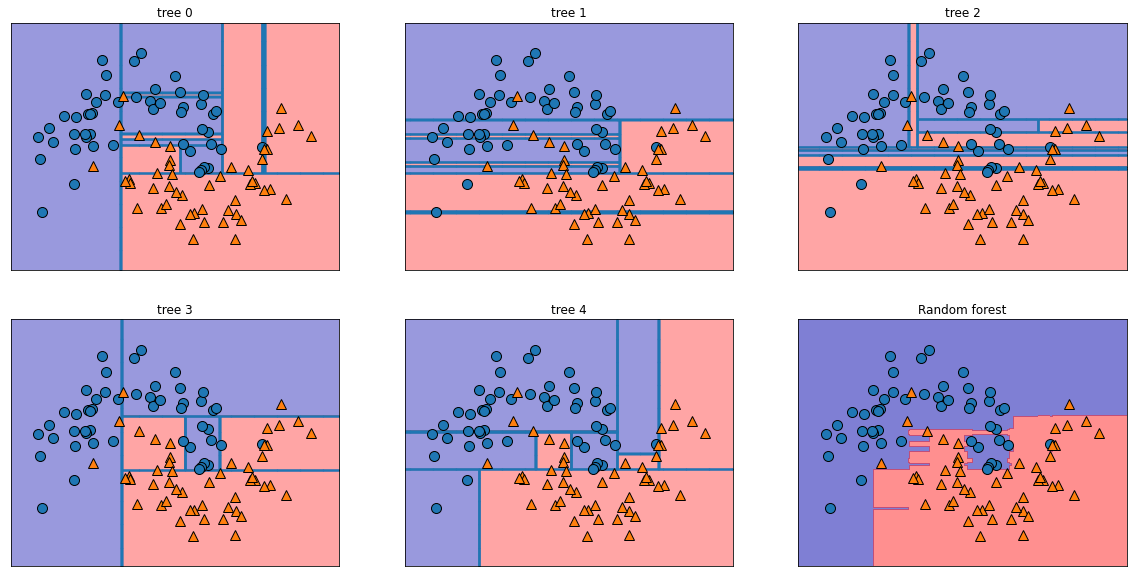

In [5]:
import matplotlib.pyplot as plt
import mglearn

# 결정 경계 시각화
# 다섯 개의 결정트리 결정 경계
fig, axes = plt.subplots(2, 3, figsize=(20,10) )
for i, (ax, tree) in enumerate( zip( axes.ravel(), model.estimators_ ) ):
    ax.set_title("tree {}".format(i) )
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)

# 랜덤포레스트로 만들어진 결정경계
axes[-1, -1].set_title("Random forest")
mglearn.plots.plot_2d_separator(model, X, fill=True, alpha=0.5, ax=axes[-1,-1] )
mglearn.discrete_scatter(X[:,0], X[:,1], y)

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# 데이터 로드
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=5, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [9]:
model = RandomForestClassifier(n_estimators=10, random_state=0,
                               oob_score=True)
model.fit(X_train, y_train)

# 평가
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train, y_train)) )
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test, y_test)) )
print("OOB 샘플의 정확도: {:.3f}".format(model.oob_score_) )

훈련 세트 정확도: 0.973
테스트 세트 정확도: 0.880
OOB 샘플의 정확도: 0.867


C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


### Bagging param
  - base_estimator (기본값 : DecisionTreeClassifier) : 기본 모델
  - n_estimators : 앙상블에 사용할 모델 개수
  - bootstrap (기본값 : True): 샘플에 대한 bootstrap 사용여부
  - bootstrap_features (기본값: False): 변수에 대한 bootstrap 사용여부
  - oob_score (기본값: False): OOB 를 일반화 오류검증에 사용할지 여부

### Bagging 의 단점
  - data를 복원 추출 하기 때문에 두 모델의 공분산이 0이 될 수가 없다.
  - $$ Var(X + Y) = Var(X) + Var(Y) + Cov(X,Y)             $$
  - 두 모델이 독립이라고 보장할수 없음! 
  - 공분산을 줄일 방법을 찾아봐야 된다.

### Data 적용

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
err_data_target = pd.read_csv('./err_model_nm_target.csv')
train_data = err_data_target.drop(['user_id','model_nm','target'],axis =1)
target_data = err_data_target['target']

In [3]:
from sklearn.model_selection import train_test_split
train_data , test_data, train_target, test_target = train_test_split(train_data, target_data)

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
model_bg = BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                          n_estimators = 5,bootstrap=True, bootstrap_features=True,
                          oob_score=True)
model_bg.fit(train_data, train_target)

C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  bootstrap_features=True, n_estimators=5, oob_score=True)

In [10]:
from sklearn.metrics import *
pred_proba = model_bg.predict_proba(test_data)
pred = model_bg.predict(test_data)
precision = precision_score( test_target, pred)
auc_score = roc_auc_score(test_target, pred_proba[:,1])

print('train_score:',model_bg.score(train_data,train_target))
print('test_score:',model_bg.score(test_data,test_target))
print('OOB:',model_bg.oob_score_)
print('AUC:',auc_score)

train_score: 0.9713287998529682
test_score: 0.756890848952591
OOB: 0.7415916191876494
AUC: 0.7238084962081509


C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
 

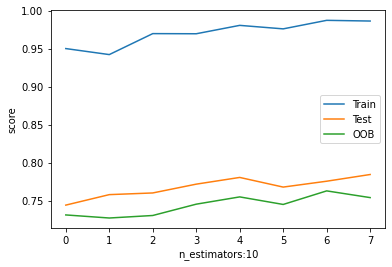

In [73]:
OOB_score = []
test_score = []
train_score = []
for i in range(3,11):
    model_bg =  BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                  n_estimators = i,bootstrap=True,
                                  bootstrap_features=True,
                                  oob_score=True)
    model_bg.fit(train_data, train_target)
    pred_proba_bg = model_bg.predict_proba(test_data)
    pred_bg = model_bg.predict(test_data)
    precision = precision_score( test_target, pred_bg)
    auc_score = roc_auc_score(test_target, pred_proba_bg[:,1])
    OOB_score.append(model_bg.oob_score_)
    test_score.append(model_bg.score(test_data,test_target))
    train_score.append(model_bg.score(train_data,train_target))

plt.plot(train_score)
plt.plot(test_score)
plt.plot(OOB_score)
plt.xlabel('n_estimators:{}'.format(i))
plt.ylabel('score')
plt.legend(['Train','Test','OOB'])
plt.show()

### base_estimator의 파라미터값 조정

In [75]:
model_bg =  BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,min_samples_split = 10),
                              n_estimators = i,bootstrap=True,
                              bootstrap_features=True,
                              oob_score=True)
model_bg.fit(train_data, train_target)
pred_proba = model_bg.predict_proba(test_data)
pred = model_bg.predict(test_data)
precision = precision_score( test_target, pred)
auc_score = roc_auc_score(test_target, pred_proba[:,1])

print('train_score:',model_bg.score(train_data,train_target))
print('test_score:',model_bg.score(test_data,test_target))
print('OOB:',model_bg.oob_score_)
print('AUC:',auc_score)

train_score: 0.8061018195184708
test_score: 0.7850055126791621
OOB: 0.785333578386326
AUC: 0.7904678754457644


C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


## Random Forest(랜덤 포레스트)
  - Bagging에서 발전된 모형으로 볼 수있다.
  - data 뿐만 아니라 변수고 sampling함.
  - Bagging 보다 공분산을 줄일 수 있다고 한다.
  - 변수가 d개 있다고 가정할때 기본적으로 랜덤으로 사용하는 변수의 개수는 $k = log_2 d$개 이다.
  - Bagging에서 발전된 모형이므로 오차율등 과 같은 지표의 수렴이 비슷하게 나타난다. (수치는 다르더라도 형태는 비슷) 

### RandomForest param
  - tree 기반 모델이므로 Decision Tree와 파라미터가 동일 하고 나머지 파라미터는 Bagging 파라미터와 동일하다.

 - 위에 결과로 보아 과적합이 된것을 알수있다.

In [82]:
from sklearn.ensemble import RandomForestClassifier
model_rt = RandomForestClassifier(n_estimators=5, random_state=42,
                               oob_score=True,bootstrap=True,max_depth=5)
model_rt.fit(train_data, train_target)

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


RandomForestClassifier(max_depth=5, n_estimators=5, oob_score=True,
                       random_state=42)

In [83]:
pred_proba_rt = model_rt.predict_proba(test_data)
pred_rt = model_rt.predict(test_data)
precision = precision_score( test_target, pred_rt)
auc_score = roc_auc_score(test_target, pred_proba_rt[:,1])

print('train_score:',model_rt.score(train_data,train_target))
print('test_score:',model_rt.score(test_data,test_target))
print('OOB:',model_rt.oob_score_)
print('AUC:',auc_score)

train_score: 0.7998529682043742
test_score: 0.7761852260198456
OOB: 0.768792501378423
AUC: 0.7804905769548686


C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

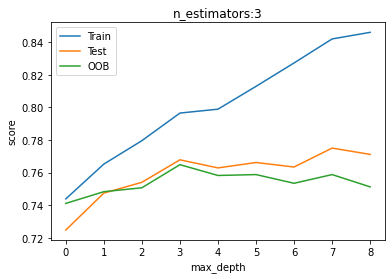

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

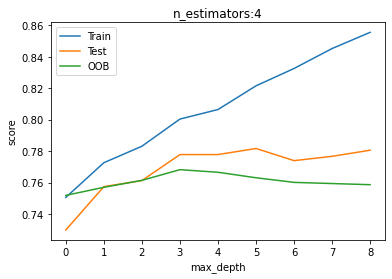

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

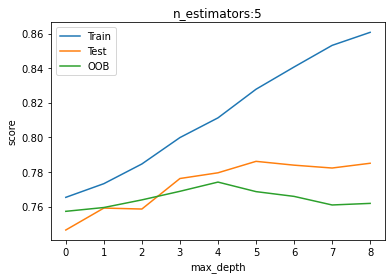

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

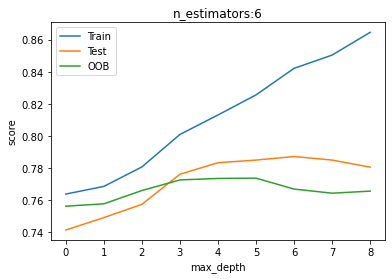

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

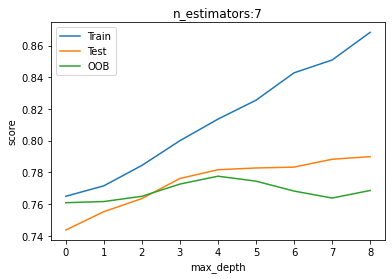

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

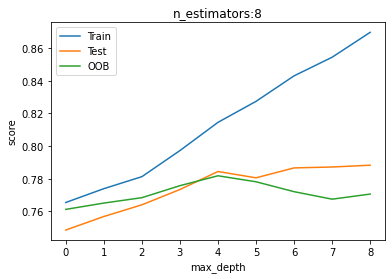

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

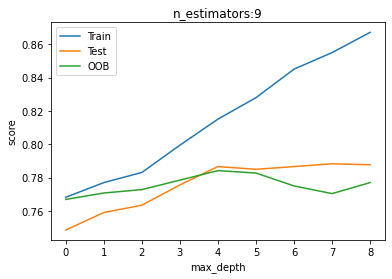

C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\anan\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB score

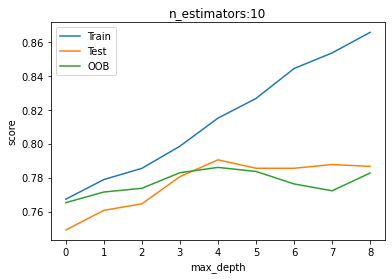

In [72]:

for i in range(3,11):
    OOB_score = []
    test_score = []
    train_score = []
    for j in range(2,11):
        model_rt = RandomForestClassifier(n_estimators=i, random_state=42,
                                          oob_score=True,bootstrap=True,max_depth=j)
        model_rt.fit(train_data, train_target)
        pred_proba_rt = model_rt.predict_proba(test_data)
        pred_rt = model_rt.predict(test_data)
        precision = precision_score( test_target, pred_rt)
        auc_score = roc_auc_score(test_target, pred_proba_rt[:,1])
        OOB_score.append(model_rt.oob_score_)
        test_score.append(model_rt.score(test_data,test_target))
        train_score.append(model_rt.score(train_data,train_target))
        
    plt.plot(train_score)
    plt.plot(test_score)
    plt.plot(OOB_score)
    plt.title('n_estimators:{}'.format(i))
    plt.xlabel('max_depth')
    plt.ylabel('score')
    plt.legend(['Train','Test','OOB'])
    plt.show()